# Sleep algorithm notebook:

### Contents:

1. Loading dependencies
2. Functions
3. Data extraction

## 1. Loading dependencies

In [3]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn import linear_model

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
from hurst import compute_Hc, random_walk
import nolds
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Functions

### 2.1 Data extraction

In [4]:
#Preprocessing
def get_df_process(filename):
    df = pd.read_csv(filename)
    if 'real_time' in df.columns:
        df["ts"] = [datetime.strptime(ts,"%d-%m-%Y %H:%M:%S") for ts in df["real_time"]] 
    else:    
        df["ts"] = [datetime.strptime(ts,"%d-%b-%Y %H:%M:%S") for ts in df["REALTIME"]] 
    #'2012-09-03"%d-%m-%Y %H:%M:%S"
    df['date'] = df['ts'].dt.date
    df['hour'] = df['ts'].dt.hour
    df.set_index(pd.DatetimeIndex(df['ts']), inplace=True)
    df['ENMO'] = (df["ACC"]/0.0060321) + 0.057
    #Creating some additional columns
    #Sedentary activities counted from 1.5 METs
    df['MET_Sed'] = df['stdMET_highIC_Branch'].apply(lambda x : 1 if x <= 0.5 else 0)
    #WHO recommendations would count moderate PA as between 3-6 METs
    df['MET_MVPA'] = df['stdMET_highIC_Branch'].apply(lambda x : x if x > 2 else 0)
    #WHO recommendations would count moderate PA as >6 METs
    df['MET_VigPA'] = df['stdMET_highIC_Branch'].apply(lambda x : x if x > 5 else 0)
    return df

def get_data(filelist):
    d = {}
    for idx, file in enumerate(filelist):
        d[idx] = pd.DataFrame()
        d[idx] = get_df_process(file)
    return d

### 2.4 Sleep algorithm ###

Some comments on the sleep algorithm:
- now there is only one quantile threshold, but for sleep it is extracted from the night HR (as you define night), while for wake periods it is extracted from the interval 09:00 - 22:00 the day before (the difference between the 2 is ~7-12 bpm)
- you can play around with the bed and wake times that define the night interval
- in the data extraction cells you can also run it for different quantiles if you give a quantiles list - ideally I'd want to optimize for the seq_length parameter too, but didn't get to that yet

In [68]:
#Function to compute the sleep windows for each subject, computed using the simple HR heuristic
#takes arguments for the start and finish times of the sleep analysis (at the moment does not look at day naps)
#takes the length of the shortest sequence deemed as sleep and the quantile for the sleep threshold

def get_tst(df, bed_time = '20:00',wake_time = '12:00',seq_length = 20, q_sleep=0.4,take_sri=False, col_sleep='sleep', col_wake='wake'):
    if all(df.ts.diff()[1:] == np.timedelta64(60, 's')) == False:
        df = df.resample('1T').mean()
    
    night = df.between_time(bed_time,wake_time, include_start = True, 
                                            include_end = True)
    day_start = '09:00'
    day_end = '22:00'
    day = df.between_time(day_start,day_end, include_start = True, 
                                            include_end = True)
    #Base is read from function input and start of day
    base_s = int(bed_time[0:2])
    base_w = int(day_start[0:2])
    
    night_count = night['mean_hr'].resample('24H',base=base_s).count()
    
    def get_threshold_bins(df, df2, col_apply, col_new, base_s, base_w,quantile,  sleep_t):
        if sleep_t:
            df[col_new] = df[col_apply].resample('24H',base=base_s).apply(lambda x: np.quantile(x,quantile))
        else:
            df[col_new] = df2[col_apply].resample('24H',base=base_w).apply(lambda x: np.quantile(x,quantile))
        df[col_new] = df[col_new].ffill(axis=0)
        #Incomplete days at the beginning are backfilled with the value for the following day
        df[col_new] = df[col_new].fillna(method='bfill')
        df[col_new+'_bin'] =np.where((df[col_apply]-df[col_new])>0, 0, 1)
        df[col_new+'_bin'] = df[col_new+'_bin'].rolling(window=5).median().fillna(method='bfill')
        df[col_new+'_seq_id'] = df.groupby((df[col_new+'_bin'] != df[col_new+'_bin'].shift(1).fillna(False)).cumsum()).ngroup()
        df[col_new+'_len'] = 0
        df[col_new+'_len'] = night[[col_new+'_len', col_new+'_seq_id']].groupby(col_new+'_seq_id').transform('count')
        return df
    
    def get_sleep_windows(df, col_sleep, base_s, min_window_length):
        df[col_sleep+'_labels'] = (df[col_sleep+'_bin']==1.0) & (df[col_sleep+'_len'] > min_window_length)
        df[col_sleep+'_labels'] = (df[col_sleep+'_labels'] == True).astype(int)
        #Extract the times when labelled sleep changes to wake and viceversa
        state_changes = df[col_sleep+'_labels'].diff().fillna(0)[lambda x: x != 0].index.tolist()
        state_changes = pd.to_datetime(state_changes).to_frame()
        #Extract index of nights available for the subject to pass onto sleep df
        index = state_changes.resample('24H',base=base_s).min().index
        sleep_df = pd.DataFrame(columns=['TST','sleep_onset','sleep_offset','weekday'], index = index)
        #Extract sleep onset each night as earliest wake-sleep transition after base hour
        sleep_df['sleep_onset'] = state_changes.resample('24H',base=base_s).min()
        #Extract sleep onset each night as last sleep-wake transition after base hour
        sleep_df['sleep_offset'] = state_changes.resample('24H',base=base_s).max()
        sleep_df['TST']= sleep_df['sleep_offset'] -  sleep_df['sleep_onset']
        sleep_df['weekday'] = sleep_df.index.dayofweek
        sleep_df = pd.DataFrame(sleep_df)
        #Label sleep windows on original df according to sleep_df
        df[col_sleep+'_window'] = np.nan
        df[col_sleep+'_window'].loc[sleep_df['sleep_onset']] = 1
        df[col_sleep+'_window'].loc[sleep_df['sleep_offset']] = 2
        df[col_sleep+'_window'] = df[col_sleep+'_window'].fillna(method='ffill')
        
        return df, state_changes, sleep_df, index
    
    def get_wake_windows(df, col_wake, base_s,min_len = 5, max_len = 60, min_interwake = 10):
        df[col_wake+'_window'] = (df[col_wake+'_bin']==0.0) & (df[col_wake+'_len'] < max_len) & (df[col_wake+'_len'] >= min_len) & (df[col_sleep+'_window']==1)    
        df[col_wake+'_window'] = (df[col_wake+'_window'] == True).astype(int)
        #Extract the times when labelled wake changes to sleep and viceversa, according to higher HR quantile
        wake_changes = df[col_wake+'_window'].diff().fillna(0)[lambda x: x != 0].index.tolist()
        wake_changes = pd.to_datetime(wake_changes)
        wake_frame = wake_changes.to_frame()
        #Delete state changes where there is less than min_interwake mins of sleep between detected awakenings
        short_wakes = []
        for i in np.arange(2, len(wake_changes)-2,2):
            if (wake_changes[i] - wake_changes[i-1])<=timedelta(minutes=min_interwake):
                short_wakes.append(i-1)
                short_wakes.append(i)
        wake_changes = pd.to_datetime([wake_changes[j] for j in set(range(len(wake_changes))) - set(short_wakes)])
        #Separate onsets and offsets of awakenings
        wake_on = [] 
        wake_off = [] 
        for i in range(len(wake_changes)): 
            if i % 2: 
                wake_off.append(wake_changes[i]) 
            else : 
                wake_on.append(wake_changes[i]) 
        #Extract awakening metrics     
        wake_df = pd.DataFrame(columns=['WASO','AwaNo'],index=index)
        df[col_wake+'_window'] = np.nan
        night[col_wake+'_window'].loc[wake_on] = 1
        wake_df['AwaNo'] = night[col_wake+'_window'].resample('24H',base=base_s).count()
        df[col_wake+'_window'].loc[wake_off] = 0
        df[col_wake+'_window'] = df[col_wake+'_window'].fillna(method='ffill')
        #Extract Wake After Sleep Onsets (minutes), adding numer of awakenings to correct for the missing min at end
        wake_df['WASO'] = df[col_wake+'_window'].resample('24H',base=base_s).sum() + wake_df['AwaNo']
        return df, wake_changes, wake_df
    
    #Execute functions
    get_threshold_bins(night, day,'mean_hr', col_sleep, base_s, base_w, quantile=q_sleep ,sleep_t=True)
    get_threshold_bins(night, day, 'mean_hr', col_wake,base_s, base_w, quantile=q_sleep,sleep_t=False)
    
    night, state_changes, sleep_df, index = get_sleep_windows(night, col_sleep, base_s,seq_length)
    night, wake_changes, wake_df = get_wake_windows(night, col_wake,base_s,min_len = 5, max_len = 60)
    
    sleep_df = pd.concat([sleep_df,wake_df], axis=1)
    #Extract sleep efficiency as (TST-WASO)/TST
    sleep_TST_delta = [(x.seconds/60) for x in sleep_df['TST'] ] 
    sleep_df['SEff'] = (sleep_TST_delta - sleep_df['WASO']) / sleep_TST_delta
    #Keep only nights with enough data (more than 10 hours available in the interval)
    sleep_df = sleep_df[night_count > 600]
    
    #Visualisation aid
    #plt.plot(night.index,night['hr_threshold_labels']*200, color='blue')
    #plt.plot(night.index,night['mean_hr']-night['hr_threshold'], color='orange')
    #plt.plot(night.index,night['hr_threshold_window']*250,color='black')
    #plt.scatter(night.index,night['wake_threshold_window']*400, color='magenta')
    #for i in range(len(sleep_df)):
    #        plt.axvspan(sleep_df['sleep_onset'][i],sleep_df['sleep_offset'][i],facecolor='grey',alpha=0.4)
    #plt.show()
    
    if take_sri == True:
        sri = get_sri(night,col_sleep+'_window')
        return sleep_df,sri
    else: 
        return sleep_df

#Function to get the sleep regularity index
def get_sri(df, sleep_col):
            sri_delta = np.zeros(len(df[df.index[0]:df.shift(periods=-1,freq='D').index[-1]]))
            for i in range(len(df[df.index[0]:df.shift(periods=-1,freq='D').index[-1]])):
                if df[sleep_col][df.index[i]] == df[sleep_col].shift(periods=-1,freq='D')[df.index[i]]:
                    sri_delta[i] = 1
                else:
                    sri_delta[i] = 0
            sri_df = pd.DataFrame(sri_delta)
            sri = -100 + (200 / (len(df[df.index[0]:df.shift(periods=-1,freq='D').index[-1]]))) * sri_df.sum()
            return float(sri)    

## 3. Data extraction

### 3.1 Get dict with main raw data for all subjects

In [5]:
filelist = ['dummy1_full.csv','dummy2_full.csv','dummy3_full.csv','dummy5_full.csv',
            'dummybbvs_1.csv', 'dummybbvs_2.csv']
d = get_data(filelist)

print(d.keys())

dict_keys([0, 1, 2, 3, 4, 5])


### 3.3 Get sleep metrics

In [72]:
def extract_sleep(d, quantiles, take_sri=False):
    sleep = defaultdict(dict)
    sleep_pop = pd.DataFrame(index=range(len(d.keys())))
    for idx in d.keys():
        for q in quantiles:
            sleep[idx][q] = pd.DataFrame()
            #Applies function to get PA data only from wake_time to bed_time
            sleep[idx][q] = get_tst(d[idx], bed_time = '20:00',wake_time = '12:00',seq_length = 20, q_sleep=q,take_sri=False)
            sleep_pop.loc[idx,'TST_avg'+str(q)] = sleep[idx][q]['TST'].mean().total_seconds()/60
            sleep_pop.loc[idx,'WASO'+str(q)] = sleep[idx][q]['WASO'].mean()
            sleep_pop.loc[idx,'AwaNo'+str(q)] = sleep[idx][q]['AwaNo'].mean()
            sleep_pop.loc[idx,'SEff'+str(q)] = sleep[idx][q]['SEff'].mean()
            if take_sri==True:
                sleep_pop.loc[idx,'SRI'+q] = sri
    return sleep, sleep_pop

quantiles = [0.3, 0.4, 0.5]
sleep, sleep_pop = extract_sleep(d,quantiles)

In [71]:
print(sleep[5].keys())
print(sleep[5][0.3])
print(sleep[5][0.4])
print(sleep_pop)


dict_keys([0.3, 0.4])
                         TST         sleep_onset        sleep_offset  weekday  \
2015-11-24 20:00:00 04:05:00 2015-11-25 02:57:00 2015-11-25 07:02:00        1   
2015-11-25 20:00:00 08:36:00 2015-11-25 22:27:00 2015-11-26 07:03:00        2   
2015-11-26 20:00:00 04:36:00 2015-11-27 02:25:00 2015-11-27 07:01:00        3   
2015-11-27 20:00:00 05:34:00 2015-11-28 01:44:00 2015-11-28 07:18:00        4   
2015-11-28 20:00:00 04:06:00 2015-11-29 05:14:00 2015-11-29 09:20:00        5   
2015-11-29 20:00:00 04:18:00 2015-11-30 02:17:00 2015-11-30 06:35:00        6   
2015-11-30 20:00:00 06:52:00 2015-11-30 23:12:00 2015-12-01 06:04:00        0   
2015-12-01 20:00:00 06:11:00 2015-12-02 01:03:00 2015-12-02 07:14:00        1   
2015-12-02 20:00:00 02:58:00 2015-12-02 23:04:00 2015-12-03 02:02:00        2   

                     WASO  AwaNo      SEff  
2015-11-24 20:00:00   0.0      0  1.000000  
2015-11-25 20:00:00  12.0      2  0.976744  
2015-11-26 20:00:00   0.0      0

### 5.5 CDF plots for HR for all data and interval of choice

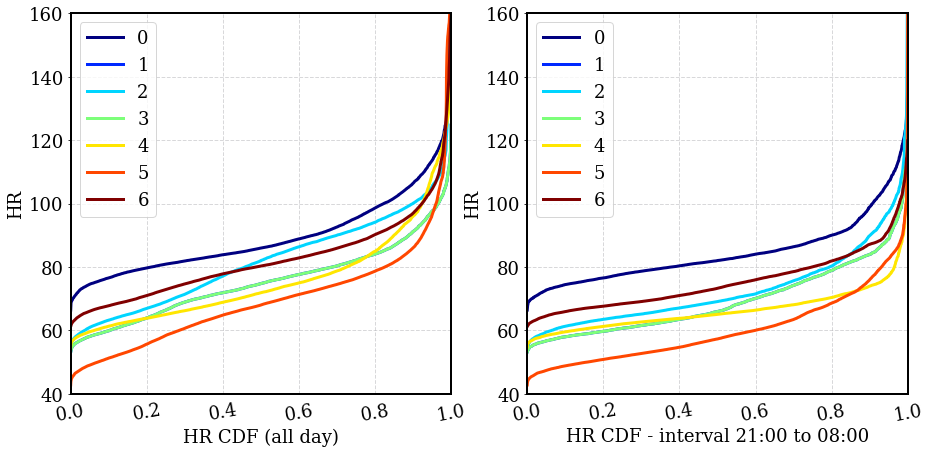

In [143]:
def plot_hr_cdf(d, start_time='21:00', end_time='09:00'):
    fig, ax1 = plt.subplots(1, 2, figsize= (15, 7))                      
    colors = pl.cm.jet(np.linspace(0,1,len(d.keys())))
    ax1[0].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=10)
    ax1[0].set_xlabel('HR CDF (all day)')
    ax1[0].grid(color='#b2b2b7', linestyle='--',linewidth=1, alpha=0.5)
    ax1[0].set_ylim(40,160)
    ax1[0].set_xlim(0,1)
    ax1[0].set_ylabel('HR')
    for idx in d.keys():
        ind = pd.Series(range(len(d[idx].index)))
        ax1[0].plot(ind.divide(len(d[idx].index)),d[idx]['mean_hr'].sort_values(), label=idx,linewidth=3, color=colors[idx],alpha=1)    
    ax1[0].legend()    
    ax1[0].set_ylabel('HR')
    
    ax1[1].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=10)
    ax1[1].set_xlabel('HR CDF - interval ' + start_time + ' to ' + end_time)
    ax1[1].grid(color='#b2b2b7', linestyle='--',linewidth=1, alpha=0.5)
    ax1[1].set_ylim(40,160)
    ax1[1].set_xlim(0,1)
    ax1[1].set_ylabel('HR')
    for idx in d.keys():
        interval = d[idx].between_time(start_time,end_time, include_start = True, 
                                            include_end = True)
        ind = pd.Series(range(len(interval.index)))
        ax1[1].plot(ind.divide(len(interval.index)),interval['mean_hr'].sort_values(), label=idx,linewidth=3, color=colors[idx],alpha=1)    
    ax1[1].legend()    
    ax1[1].set_ylabel('HR')
        
plot_hr_cdf(d,start_time='21:00', end_time='08:00')

#Plotting METmins and sleep windows for all subjects
def plot_hr_cdf_one(d, start_time='21:00', end_time='09:00'):
    fig, ax1 = plt.subplots(len(d.keys()), 1, figsize= (10, 25))
    #ax1.set_title("Physical activity and sedentary time per hour")                        
    for idx in d.keys():
        interval = d[idx].between_time(start_time,end_time, include_start = True, 
                                            include_end = True)
        ax1[idx].tick_params(axis='x', which='both',bottom=False,top=False, labelbottom=True, rotation=10)
        ax1[idx].set_xlabel('HR CDF all day and interval: ' + start_time + ' to ' + end_time)
        #ax1[idx].set_ylim(0,max(df2_h['MET_MVPA']))
        ax1[idx].grid(color='#b2b2b7', linestyle='--',linewidth=1, alpha=0.5)
        ind = pd.Series(range(len(d[idx].index)))
        ax1[idx].plot(ind.divide(len(d[idx].index)),d[idx]['mean_hr'].sort_values(), label='HR',linewidth=3, color ='green',alpha=1)
        ind_interval = pd.Series(range(len(interval.index)))
        ax1[idx].plot(ind_interval.divide(len(interval.index)),interval['mean_hr'].sort_values(), label='HR_interval',linewidth=3, color ='blue',alpha=1)
        ax1[idx].set_ylabel('HR')
        ax1[idx].legend()
        ax1[idx].set_ylim(40,180)
        ax1[idx].set_xlim(0,1)
        
#plot_hr_cdf_one(d, start_time='21:00', end_time='09:00')